In [1]:
import pandas as pd
import numpy as np

### Особенность
Для устройств Android наблюдаем более высокие юзерские отмены. 
Цель - попытаемся снизить долю юзерских отмен на Android'ах.

### Гипотеза
Если пользователям Android показывать сообщение с вопросом «Вы точно хотите отменить заказ? Водитель расстроится!», когда они нажимают кнопку отказа, то среднеюзерная доля отказов среди заказанных поездок у владельцев смартфонов с Android понизится, поскольку им станет эмоционально тяжелее отказываться от поездки.

Для начала загружаем и оформляем датафрейм для работы.

In [2]:
df = pd.read_csv('Netology_A_B-testing.csv')

In [3]:
df = df.drop(df.columns[[0]], axis=1)

In [4]:
df.head()

,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
0,2020-05-21,867689,12,1,1,1,no surge,1,0,20,iOS,0,business,7.982135,low
1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium


В силу специфики гипотезы, нас будут интересовать только наблюдения, где заказ был совершен (order_made = 1).

In [49]:
df_ordered = df[df.order_made == 1]
df_ordered.head()

,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
0,2020-05-21,867689,12,1,1,1,no surge,1,0,20,iOS,0,business,7.982135,low
1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium


Из датафрейма с совершенными заказами сформируем датафрейм, в котором оставим только пользователей Android.

In [50]:
df_android = df_ordered[df_ordered.os == 'Android']

In [63]:
df_android.head()

,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium
7,2020-05-22,682337,2,1,1,1,no surge,1,0,40,Android,1,comfort,9.055344,medium


Сгруппируем данные по юзерам, и оставим два солбца, которые нам нужны: совершение заказа (order_made) и отмену (user_cancelled).

In [52]:
df_android_user = df_android.groupby('user_id').sum()[['order_made', 'user_cancelled']]

In [53]:
df_android_user.head()

,order_made,user_cancelled
user_id,,
100093,2,0
100118,2,1
100134,3,1
100166,4,1
100255,1,1


Посчитаем среднюю долю отмененных заказов на каждого юзера.

In [54]:
df_android_user['avg_cancelled'] = df_android_user.user_cancelled / df_android_user.order_made

In [55]:
df_android_user.head()

,order_made,user_cancelled,avg_cancelled
user_id,,,
100093,2,0,0.000000
100118,2,1,0.500000
100134,3,1,0.333333
100166,4,1,0.250000
100255,1,1,1.000000


Чтобы разбить пользователей на две группы для теста, присвоим каждому случайным образом число 1 или 2.

In [56]:
df_android_user['rand_group'] = np.random.randint(1,3, size=len(df_android_user))

In [57]:
df_android_user.head()

,order_made,user_cancelled,avg_cancelled,rand_group
user_id,,,,
100093,2,0,0.000000,2
100118,2,1,0.500000,2
100134,3,1,0.333333,1
100166,4,1,0.250000,1
100255,1,1,1.000000,1


In [58]:
import matplotlib.pyplot as plt

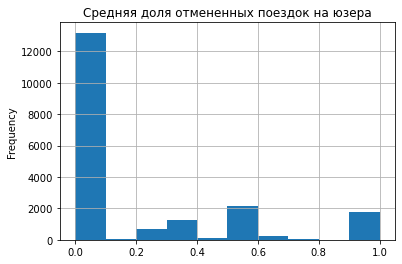

In [65]:
df_android_user['avg_cancelled'].plot(kind='hist',
                   title='Средняя доля отмененных поездок на юзера', grid=True, bins = 10)
plt.show()

Видим, что распределение средних не похоже на нормальное. Поэтому применять t-тест будет некорректно. Тем не менее, сделаем это, чтобы попробовать применить инструментарий t-теста.

Отнесем пользователей к группе 1 или группе 2 в зависимости от присвоенного ранее числа.

In [60]:
df_group_1 = df_android_user.loc[df_android_user.rand_group == 1]
df_group_1.head()

,order_made,user_cancelled,avg_cancelled,rand_group
user_id,,,,
100134,3,1,0.333333,1
100166,4,1,0.250000,1
100255,1,1,1.000000,1
100275,1,0,0.000000,1
100303,1,0,0.000000,1


In [61]:
df_group_2 = df_android_user.loc[df_android_user.rand_group == 2]
df_group_2.head()

,order_made,user_cancelled,avg_cancelled,rand_group
user_id,,,,
100093,2,0,0.0,2
100118,2,1,0.5,2
100313,2,1,0.5,2
100434,1,0,0.0,2
100452,2,1,0.5,2


Проведем t-тест.

In [26]:
import scipy

In [37]:
from scipy import stats

In [62]:
scipy.stats.ttest_ind(df_group_1['avg_cancelled'], df_group_2['avg_cancelled'])

Ttest_indResult(statistic=-0.4574404460442294, pvalue=0.6473595883742121)

Как видим, даже на 10% уровне значимости мы не можем утверждать, что нулевая гипотеза о равенстве средних значений между двумя выборками отвергается. Значит, можем считать, что для наших целей две группы пользователей значимо не отличаются по параметру средней доли отмененных поездок, и мы можем использовать это разбиение для A/B теста. Правда, относиться к этому результату нужно с осторожностью, поскольку изначальное распределение пользователей не только не было нормальным, что по идее делает его неподходящим для t-теста, но и характеризовалось тяжелым хвостом, который ведет себя немонотонно, из-за чего возможно и ЦПТ не выполнялась.

### Особенность
Если заказ из центра, то видим более низкие юзерские отмены. Можно сделать несколько предположений, почему такая особенность наблюдается. Возможно, при заказе из центра пользователь спешит, или устал после работы, или пьян :) и у него нет времени или сил сравнивать ценовые предложения других агрегаторов, пока он ждет водителя. Юзеры, заказывающие не из центра, возможно наоборот обладают в этот момент большей гибкостью с точки зрения выбора времени поездки (предполагаемая логика: сначала заказал, потом подумал, понял что дорого, и отменил; заказал, посмотрел цены других агрегаторов, пока ждет, нашел цену лучше, отменил). Допустим, мы хотим снизить юзерские отмены при поездках в центр.

### Гипотеза
Если при поездке в центр пользователю показывать сообщение с вопросом «Вы точно хотите отменить заказ? Водитель расстроится!», когда они нажимают кнопку отказа, то среднеюзерная доля отказов среди заказанных поездок в центр понизится, поскольку им станет эмоционально тяжелее отказываться от поездки.

Из датафрейма с совершенными заказами (df_ordered), сформированного ранее, сформируем датафрейм, в котором оставим только поездки в центр (city_center_order = 0).

In [66]:
df_centerbound = df_ordered[df_ordered.city_center_order == 0]
df_centerbound.head()

,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
0,2020-05-21,867689,12,1,1,1,no surge,1,0,20,iOS,0,business,7.982135,low
2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium
10,2020-05-23,464055,20,1,1,1,surge,1,0,59,iOS,0,comfort,3.647097,high
11,2020-05-24,370093,12,1,1,1,no surge,1,0,27,Android,0,economy,4.273224,medium


Группируем по пользователям, и оставляем количество заказов и количество отмен у каждого.

In [67]:
df_centerbound_user = df_centerbound.groupby('user_id').sum()[['order_made', 'user_cancelled']]
df_centerbound_user.head()

,order_made,user_cancelled
user_id,,
100093,2,0
100118,5,1
100134,2,1
100166,3,1
100255,3,0


Посчитаем среднюю долю отмененных заказов на каждого юзера.

In [69]:
df_centerbound_user['avg_cancelled'] = df_centerbound_user.user_cancelled / df_centerbound_user.order_made
df_centerbound_user.head()

,order_made,user_cancelled,avg_cancelled
user_id,,,
100093,2,0,0.000000
100118,5,1,0.200000
100134,2,1,0.500000
100166,3,1,0.333333
100255,3,0,0.000000


Чтобы разбить пользователей на две группы для теста, присвоим каждому случайным образом число 1 или 2.

In [71]:
df_centerbound_user['rand_group'] = np.random.randint(1,3, size=len(df_centerbound_user))
df_centerbound_user.head()

,order_made,user_cancelled,avg_cancelled,rand_group
user_id,,,,
100093,2,0,0.000000,1
100118,5,1,0.200000,1
100134,2,1,0.500000,1
100166,3,1,0.333333,2
100255,3,0,0.000000,2


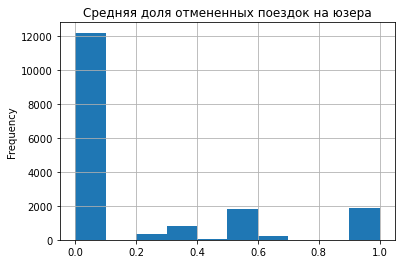

In [72]:
df_centerbound_user['avg_cancelled'].plot(kind='hist',
                   title='Средняя доля отмененных поездок на юзера', grid=True, bins = 10)
plt.show()

По графику видим, что ситуация очень похожа на предыдущую. Тем не менее, применим t-тест.

Отнесем пользователей к группе A или группе B в зависимости от присвоенного ранее числа.

In [74]:
df_group_a = df_centerbound_user.loc[df_centerbound_user.rand_group == 1]
df_group_a.head()

,order_made,user_cancelled,avg_cancelled,rand_group
user_id,,,,
100093,2,0,0.0,1
100118,5,1,0.2,1
100134,2,1,0.5,1
100303,1,0,0.0,1
100313,1,0,0.0,1


In [75]:
df_group_b = df_centerbound_user.loc[df_centerbound_user.rand_group == 2]
df_group_b.head()

,order_made,user_cancelled,avg_cancelled,rand_group
user_id,,,,
100166,3,1,0.333333,2
100255,3,0,0.000000,2
100275,2,0,0.000000,2
100375,2,1,0.500000,2
100405,1,0,0.000000,2


Проведем t-тест.

In [76]:
scipy.stats.ttest_ind(df_group_a['avg_cancelled'], df_group_b['avg_cancelled'])

Ttest_indResult(statistic=1.4443564228536947, pvalue=0.1486569117729573)

Аналогично предыдущей ситуации, даже на 10% уровне значимости мы не можем утверждать, что нулевая гипотеза о равенстве средних значений между двумя выборками отвергается. Значит, можем считать, что для наших целей две группы пользователей значимо не отличаются по параметру средней доли отмененных поездок, и мы можем использовать это разбиение для A/B теста. Ограничения те же, что и в предыдущем случае.